# 1. Problem Framing & Technical Summary

## 1.1. The Problem

We are a data science consultancy that has been hired by a large hotel chain to investigate viable methods of mitigating the impact of customer cancellations. The approach taken in this analysis was to look at what characteristics of an individual may indicate that they are of a high probability to cancel. If an individual is deemed likely to cancel, they are charged a higher deposit at the point of purchase. This means that some of the lost revenue due to cancellation is recovered, thus reducing the overall cost to our client. We take ethics very seriously so for obvious reasons race, religion, gender and biological sex have not been considered. All customers will pay the same overall price (if they are purchasing the same product), it is only the initial deposit (as a % of the total price) that will change on a customer to customer basis.

## 1.2. Technical Summary

The dataset had a total of 79330 instances. The target variable was whether or not the customer had cancelled. The total number of cancellations in the dataset were 33076. 

The following models were created, many of which had multiple iterations where there hyperparameters were tuned for optimal performance:

- Logistic Regression Classifier
- Decision Tree Classifier
- Random Forest Classifier
- Voting Classifier
- AdaBoost Classifier
- XGBoost Classifier
- Stacking Classifier

The best performing model was a stacking classifier configured with a logistic regression, decision tree and random forest model. It achieved an AUC ROC of 0.953402 however due to its complexity it was not chosen as the final model. The random forest model was the next best performer with a score of 0.952503. The performance was approximately the same as the stacking classifier and its complexity was much reduced, resulting in faster run times. Its optimal hyperparameters were max_depth=70 and min_samples_leaf=1.

The optimum threshold for this model was 0.448167, meaning any individual deemed to have a probability > 0.448167 of cancelling was classified as someone that will cancel. With this threshold we are able to achieve a true positive rate of 99.6% and a true negative rate of 99.7%.

Our suggestions are to increase the base level of deposit from 25% to 50% for individuals that are classified as likely to cancel. We estimate this would result in a 20,000€ increase in revenue per 1000 bookings, equating to 790,000€ per year.

## 1.3. Document Structure

1. Problem Framing & Technical Summary
2. Importing Libraries
3. Exploratory Data Analysis
4. Preprocessing
5. Modelling
6. Model Evaluation
7. Feature Importance
8. Threshold Selection & Actionable Recommendations

# 2. Importing Libraries

In [1]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# 3. Exploratory Data Analysis

This section is an initial exploration of the dataset.

In [2]:
df = pd.read_csv('H2.csv')

In [3]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [4]:
len(df)

79330

In [5]:
df['IsCanceled'].value_counts()

0    46228
1    33102
Name: IsCanceled, dtype: int64

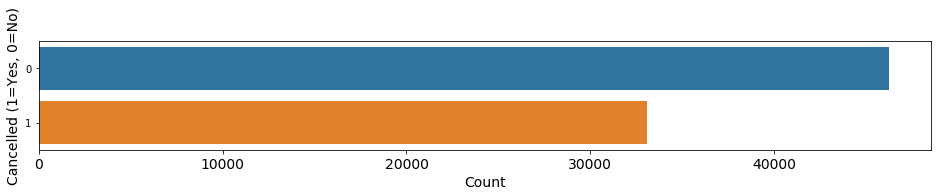

In [6]:
fig = plt.figure(figsize=(16,2))
sns.countplot(y='IsCanceled', data=df)
plt.ylabel('Cancelled (1=Yes, 0=No)', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.show()

The 'IsCancled' class is our target variable. It is fairly balanced with 41.7% of the instances being of the positive class.

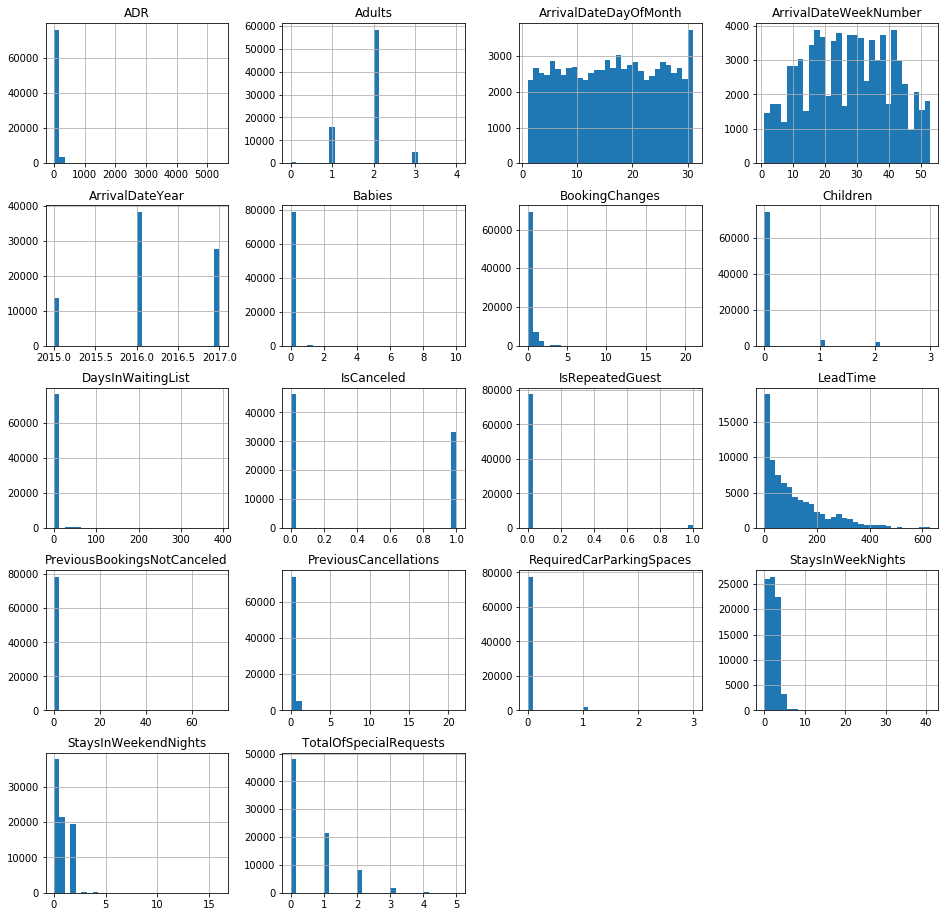

In [8]:
df.hist(bins=30, figsize=(16,16))
plt.show()

# 4. Preprocessing

## 4.1. Cleaning

In this section we prepare the data for the modelling that is to come later. Nulls were removed and unwated features were ommited.

In [9]:
df.isna().sum().sum()

28

In [10]:
df = df.dropna()

In [11]:
df.isna().sum().sum()

0

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
df.drop(columns=['ReservationStatusDate', 
                 'ReservationStatus', 
                 'ArrivalDateYear', 
                 'BookingChanges',
                 'Company',
                 'DepositType'], inplace=True)

'ReservationStatusDate' was removed as we have the day of the week and month of the year as their own individual features. 'ArrivalDateYear' was removed as the models are going to be used for booking being made in the future, therefore historic years will have no predictive power. 'BookingChanges' was removed because the increased deposit is going to be charged at the point of purchase, therefore it will not be known how many booking chages will be made, as these will occur after the booking is complete. 'Company' was removed as this was mostly null values, the cells were populated but with a string saying 'NULL'. 'DepositType' was not considered as we wanted to solely focus on the effects of inreasing the deposit.

## 4.2. One Hot Encoding

In the cells below the categorical variables are made into binary variables using the pandas get_dummies() function. For this to work the categorical and numerical feeatures must be identified and put into lists.

In [14]:
y = df[['IsCanceled']]
X = df.drop(columns=['IsCanceled'])

In [15]:
num_features = ['LeadTime',
            'StaysInWeekendNights',
            'StaysInWeekNights',
            'Adults',
            'Children',
            'Babies',
            'PreviousCancellations',
            'PreviousBookingsNotCanceled',
            'DaysInWaitingList',
            'ADR',
            'RequiredCarParkingSpaces',
            'TotalOfSpecialRequests']

df_num = X[num_features]

df_cat = X.drop(columns=num_features)

cat_features = list(df_cat.columns)

In [16]:
X_drop = pd.get_dummies(X, columns=cat_features, drop_first=True)

In [17]:
X_drop.isnull().sum().sum()

0

In [18]:
X_drop.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,DaysInWaitingList,ADR,...,Agent_ 475,Agent_ 476,Agent_ 480,Agent_ 484,Agent_ 495,Agent_ 509,Agent_ NULL,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,6,0,2,1,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,88,0,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
2,65,0,4,1,0.0,0,0,0,0,68.0,...,0,0,0,0,0,0,0,0,1,0
3,92,2,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
4,100,0,2,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0


In [19]:
X = pd.get_dummies(X, columns=cat_features)

In [20]:
X.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,DaysInWaitingList,ADR,...,Agent_ 476,Agent_ 480,Agent_ 484,Agent_ 495,Agent_ 509,Agent_ NULL,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,6,0,2,1,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,88,0,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
2,65,0,4,1,0.0,0,0,0,0,68.0,...,0,0,0,0,0,0,0,0,1,0
3,92,2,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
4,100,0,2,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0


## 4.3. Train-Test split & KFold Validation

In order to be able to validate the model we had to split the dataset into train, validation and test segments.

In [21]:
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.25, 
                                                                    random_state=50)

In [22]:
X_train_initial_drop, X_test_drop, y_train_initial_drop, y_test_drop = train_test_split(X, 
                                                                                        y, 
                                                                                        test_size=0.25, 
                                                                                        random_state=50)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, 
                                                  y_train_initial, 
                                                  test_size=0.25,
                                                  random_state=50)

In [24]:
X_train_drop, X_val_drop, y_train_drop, y_val_drop = train_test_split(X_train_initial_drop, 
                                                                      y_train_initial_drop, 
                                                                      test_size=0.25,
                                                                      random_state=50)

KFold cross validation is used with 3 folds.

In [25]:
skf = StratifiedKFold(n_splits=3,random_state=50)

## 4.4. Scaling

For the logistic regression model to be run in the next section, the data needed to be scaled. Not only does this increase the speed of the optimisation, but it is also importnat for the l1 and l2 penalties that may be aplied, as these will be dependent upon the relative size of the features. The transformation was done using StandardScaler.

### 4.4.1. Training Data

In [26]:
X_train_cat = X_train_drop.drop(columns=num_features)

In [27]:
X_train_cat.reset_index(drop=True, inplace=True)

In [28]:
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train_drop[num_features]))

In [29]:
X_train_s.columns = num_features

In [30]:
X_train_s = pd.concat([X_train_s, X_train_cat], axis=1)

### 4.4.2. Validation Data

In [31]:
X_val_cat = X_val_drop.drop(columns=num_features)

In [32]:
X_val_cat.reset_index(drop=True, inplace=True)

In [33]:
X_val_s = pd.DataFrame(scaler.transform(X_val_drop[num_features]))

In [34]:
X_val_s.columns = num_features

In [35]:
X_val_s = pd.concat([X_val_s, X_val_cat], axis=1)

### 4.4.3. Test Data

In [36]:
X_test_cat = X_test_drop.drop(columns=num_features)

In [37]:
X_test_cat.reset_index(drop=True, inplace=True)

In [38]:
X_test_s = pd.DataFrame(scaler.transform(X_test_drop[num_features]))

In [39]:
X_test_s.columns = num_features

In [40]:
X_test_s = pd.concat([X_test_s, X_test_cat], axis=1)

# 5. Modelling

## 5.1. Modelling Class

In this section a class is made so that the process of creating and evaluating the models is more efficient later on.

The functions and their uses are as follows:

1. \_\_init__ : model is initialised.
2. scores : the AUC (Area Under the Curve) of the ROC (Receiver Operating Characteristic) is calculated. This is the metric by which the models are to be compared on.
3. annot : annotating the ROC plot with the threshold values.
4. roc_plot : creating the ROC plot.
5. get_scores : GridSearchCV is used to cross validate each model variant (the hyperparameters changing each time). It returns the hyperparameters that had the highest validation AUC score.
6. opt_plots : this function creates a heatmap showing the performance of all model variants. This allows for the tuning of hyperparameters in the following iterations.
7. conf_matrix : the number of true positives, true negatives, false positive and false negatives on the validation data are calculated.
7. pretty_conf_matrix : this function simply plots the results of the conf_matrix function above.
8. plot_dtree : this function plots the decision tree models.

In [41]:
class Classification():
    
    def __init__(self, model, X_train, X_val, y_train, y_val):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Logistic Regression':
            self.instantiate = LogisticRegression(fit_intercept=False)
        elif self.model == 'Decision Tree':
            self.instantiate = DecisionTreeClassifier(random_state=50)
        elif self.model == 'Random Forest':
            self.instantiate = RandomForestClassifier(n_estimators=100, 
                                                          n_jobs=-1,
                                                          random_state=50)
        elif self.model == "SVM":
            self.instantiate = SVC(probability=True,
                                   random_state=50)
        
# SCORE FUNCTION -------------------------------------------------------------
        
    def scores(self, model, X_train, X_val, y_train, y_val):
        
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        
        train_auc = roc_auc_score(y_train, train_prob)
        val_auc = roc_auc_score(y_val, val_prob)
        
        self.train_auc = train_auc
        self.val_auc = val_auc
        
        self.scores_table = pd.DataFrame()
        
        self.scores_table["Model"] = [self.model]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]
        
        return self.scores_table
    
# THRESHOLD ANNOTATION -------------------------------------------------------

    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k % 100 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
            
# ROC PLOT FUNCTION ----------------------------------------------------------

    def roc_plot(model, X_train, X_val, y_train, y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]:
            fpr, tpr, thresh = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, thresh)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        
# GET SCORES FUNCTION --------------------------------------------------------

    def get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,
                                            self.best_model,
                                            self.X_train,
                                            self.X_val,
                                            self.y_train,
                                            self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
# OPTIMUM PLOT FUCNTION ------------------------------------------------------

    def opt_plots(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params, opt[cols]], axis=1, sort=False)
            
            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
            
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
# CONFUSION MATRIX FUNCTION --------------------------------------------------

    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
        
# DISPLAY PRETTY CONFUSION MATRIX FUNCTION -----------------------------------

    def pretty_conf_matrix(self):
        
        Classification.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

# PLOT DECISION TREE FUCNTION ------------------------------------------------

    def plot_dtree(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            
            dot_data = StringIO()
            export_graphviz(self.best_model, 
                            out_file=dot_data, 
                            filled=True,
                            rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
            graph.write_png(f'{self.model}.png')
            image = mpimg.imread(f'{self.model}.png')
            plt.figure(figsize=(50,50))
            plt.imshow(image)
            plt.show()
            
        else:
            
            print("This model does not have a decision tree plot!")


## 5.2. Logistic Regression

### 5.2.1. Logistic Regression 1

This logistic regression model was completed using the scaled dataset with the first column of the one hot encoded categorical varibales dropped.

In [42]:
logistic_regression1 = Classification('Logistic Regression', X_train_s, X_val_s, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.90271,0.899049


The best hyperparameters are:  {'C': 1, 'solver': 'liblinear'} 



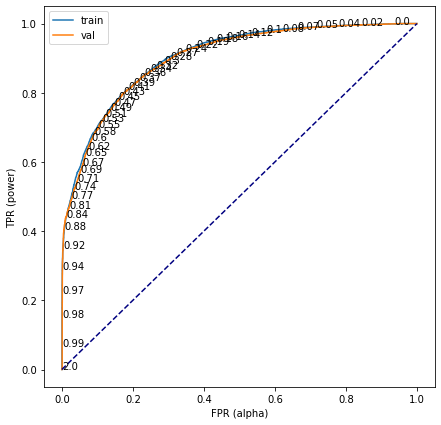

In [43]:
param_grid = {'C':[0.1,1,10,100],
              'solver':['lbfgs','liblinear','sag','saga']}
logistic_regression1.get_scores(param_grid, skf)

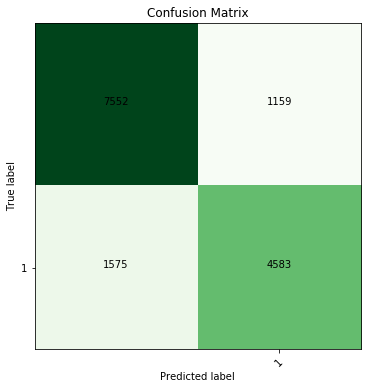

In [44]:
logistic_regression1.pretty_conf_matrix()

### 5.2.2. Logistic Regression 2

This logistic regression model was completed with unscaled data and with all of the one hot encoded categorical variables. This was done becuase for the ensemble methods in later sections, logistic regression is used alongside decision tree and random forest models, so we wanted to observe how the model performed by itself when using the same data that the decision tree and random forest models use. Due to the unscaled variables, only l1 regularisation was used.

In [45]:
logistic_regression2 = Classification('Logistic Regression', X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.90231,0.898818


The best hyperparameters are:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} 



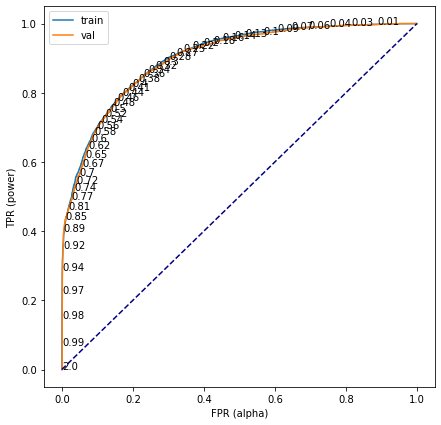

In [46]:
param_grid = {'C':[0.1,1,10,100],
              'penalty':['l1'],
              'solver':['liblinear','saga']}
logistic_regression2.get_scores(param_grid, skf)

It is clear that the performance reduction from using the unscaled dataset with all of the one hot encoded categorical variables is very minimal. Therefore in the ensemble models, this is the model that will be used.

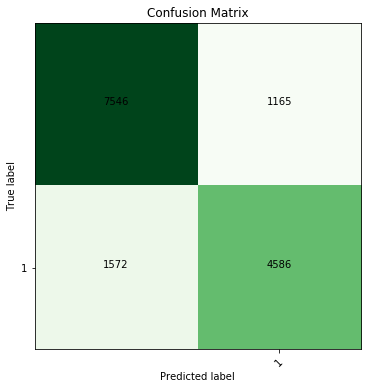

In [47]:
logistic_regression2.pretty_conf_matrix()

## 5.3. Decision Tree

### 5.3.1. Decision Tree Iteration 1

,Model,Train AUC,Validation AUC
0,Decision Tree,0.928967,0.919693


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 10} 



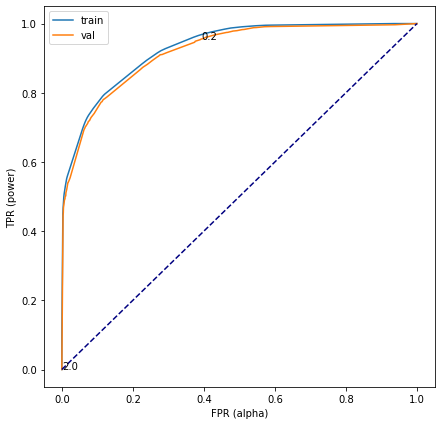

In [48]:
param_grid = {'max_depth':[1,10,100,1000], 'min_samples_leaf':[1,10,100,1000]}
decision_tree1 = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree1.get_scores(param_grid, skf)

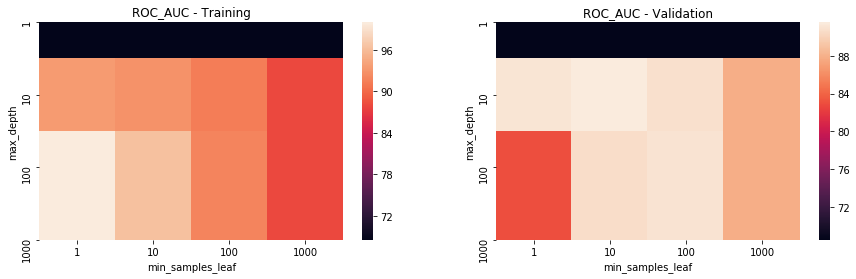

In [49]:
decision_tree1.opt_plots()

### 5.3.2. Decision Tree Iteration 2

,Model,Train AUC,Validation AUC
0,Decision Tree,0.948526,0.923626


The best hyperparameters are:  {'max_depth': 20, 'min_samples_leaf': 20} 



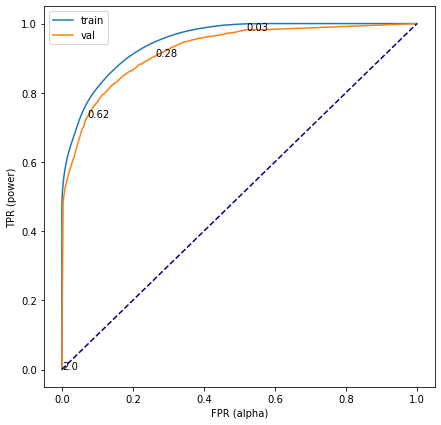

In [50]:
param_grid = {'max_depth':range(10,150,10), 'min_samples_leaf':range(10,150,10)}
decision_tree2 = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree2.get_scores(param_grid, skf)

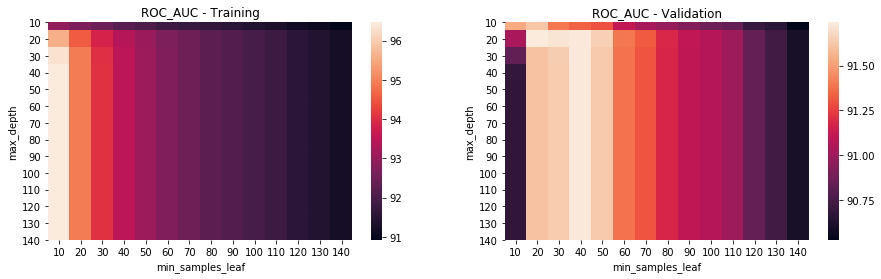

In [51]:
decision_tree2.opt_plots()

### 5.3.3. Decision Tree Iteration 3

,Model,Train AUC,Validation AUC
0,Decision Tree,0.938816,0.924455


The best hyperparameters are:  {'max_depth': 14, 'min_samples_leaf': 23} 



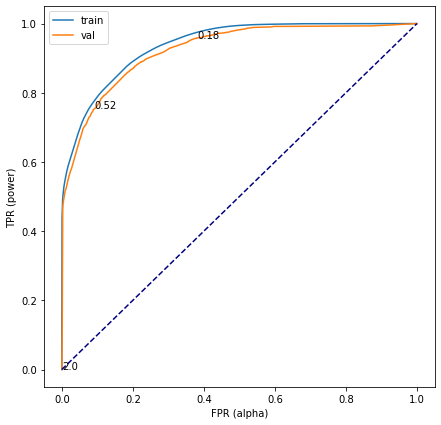

In [52]:
param_grid = {'max_depth':range(10,30,1), 'min_samples_leaf':range(10,30,1)}
decision_tree3 = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree3.get_scores(param_grid, skf)

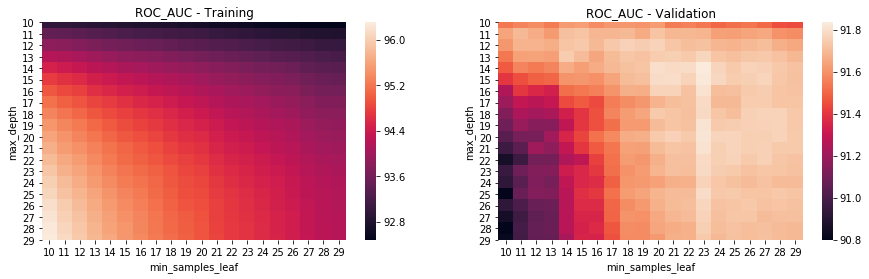

In [53]:
decision_tree3.opt_plots()

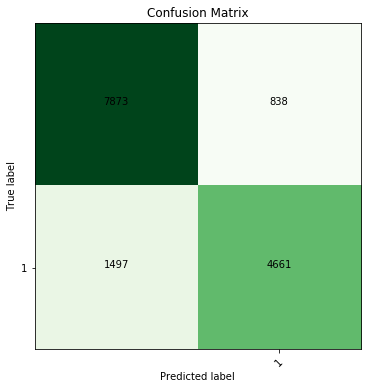

In [54]:
decision_tree3.pretty_conf_matrix()

## 5.4. Random Forest

### 5.4.1. Random Forest Iteration 1

,Model,Train AUC,Validation AUC
0,Random Forest,0.999528,0.952546


The best hyperparameters are:  {'max_depth': 10000, 'min_samples_leaf': 1} 



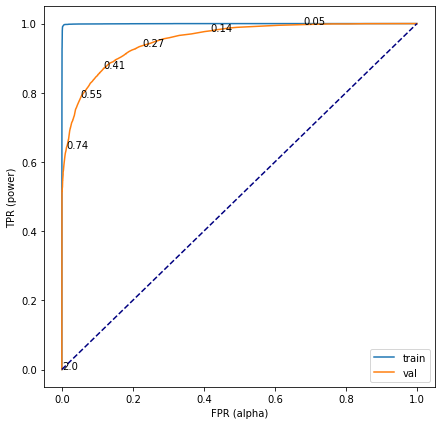

In [55]:
param_grid = {'max_depth':[10,100,1000,10000], 'min_samples_leaf':[1,10,100,1000]}
random_forest1 = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest1.get_scores(param_grid, skf)

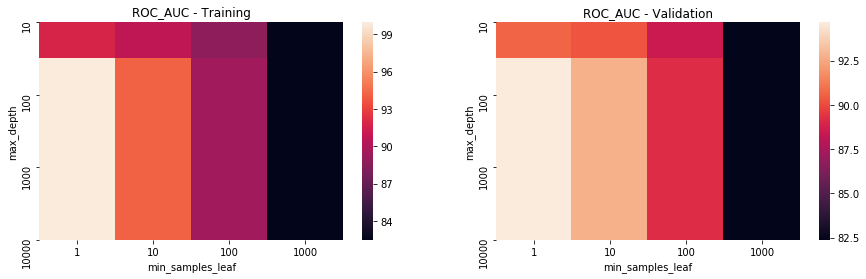

In [56]:
random_forest1.opt_plots()

### 5.4.2. Random Forest Iteration 2

The random forest model was run again, this time with narrower hyperparameters that foused closer to the region that performed best in the last iteration. Interestingly, th auc score was very slightly lower this time, despite the range containing the best performing hyperparameter from the previous iteration. Initially it was thought that this was due to the random state not having been set in the model, however it had been set and was constant for both iterations. After some research it was found that this is likely a multiprocessing issue (n_jobs=-1). If we were to run the model on just a single score (n_jobs=1) the scores would be more reproducible, however due to the length of time it takes to run this model and the minute drop in performance, it was decided to continue with the results we have below. More can be read on the reproducibility issue here:

https://github.com/scikit-learn/scikit-learn/issues/10237


,Model,Train AUC,Validation AUC
0,Random Forest,0.999208,0.951905


The best hyperparameters are:  {'max_depth': 50, 'min_samples_leaf': 1} 



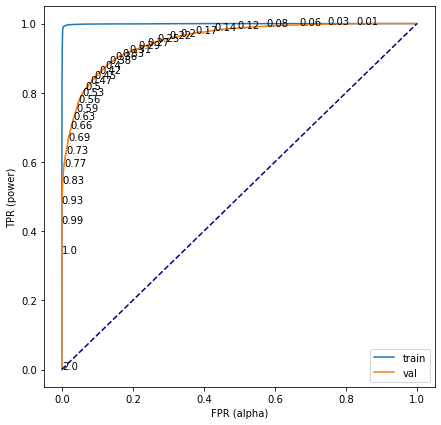

In [57]:
param_grid = {'max_depth':range(50,2000,50), 'min_samples_leaf':range(1,11,1)}
random_forest2 = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest2.get_scores(param_grid, skf)

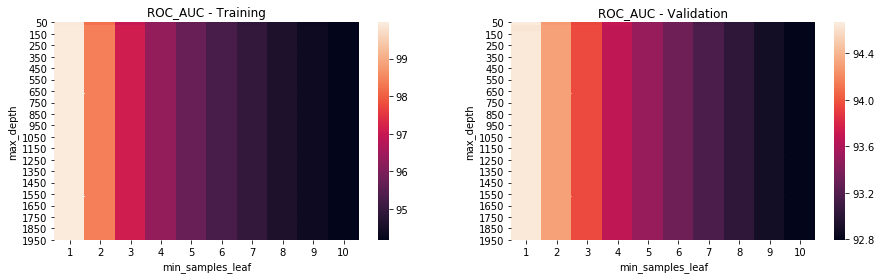

In [58]:
random_forest2.opt_plots()

### 5.4.3. Random Forest Iteration 3

The best performing hyperparameters from the last iteration were at the lower limit of the range, therefore in this iteration the range was lowered.

,Model,Train AUC,Validation AUC
0,Random Forest,0.999469,0.952503


The best hyperparameters are:  {'max_depth': 70, 'min_samples_leaf': 1} 



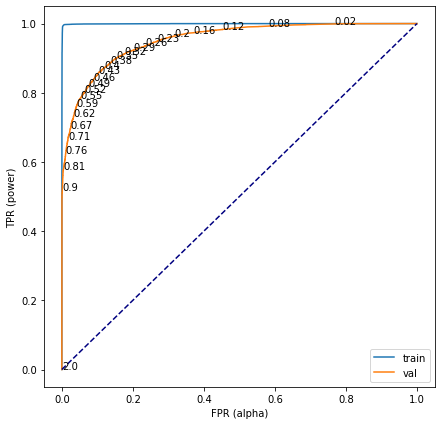

In [60]:
param_grid = {'max_depth':range(10,101,5), 'min_samples_leaf':range(1,4,1)}
random_forest3 = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest3.get_scores(param_grid, skf)

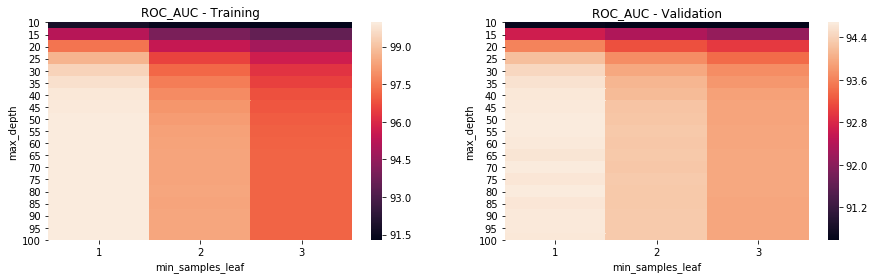

In [61]:
random_forest3.opt_plots()

### 5.4.4. Random Forest Iteration 4

,Model,Train AUC,Validation AUC
0,Random Forest,0.999469,0.952503


The best hyperparameters are:  {'max_depth': 70, 'min_samples_leaf': 1} 



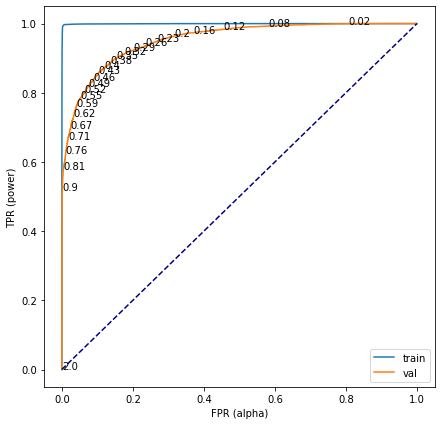

In [62]:
param_grid = {'max_depth':range(60,81,1), 'min_samples_leaf':range(1,3,1)}
random_forest4 = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest4.get_scores(param_grid, skf)

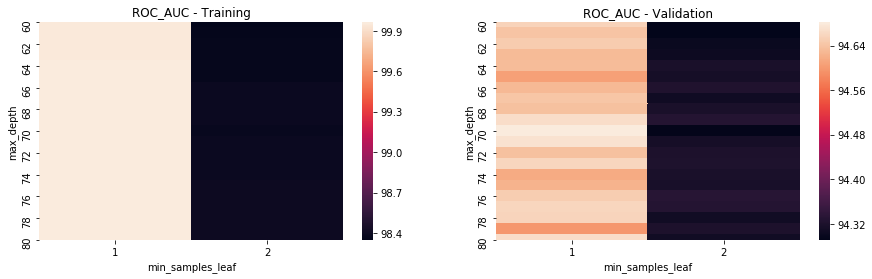

In [63]:
random_forest4.opt_plots()

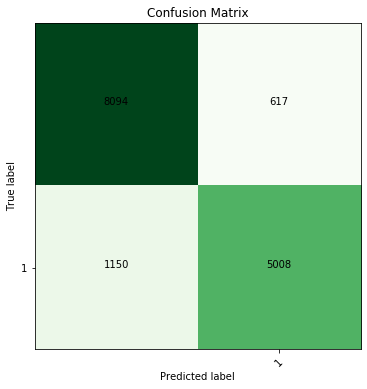

In [64]:
random_forest4.pretty_conf_matrix()

## 5.5. Ensemble Class

In [65]:
class Ensemble(Classification):
    
    def __init__(self, ensemble_method, estimators, X_train, X_val, y_train, y_val):
        
        self.ensemble_method = ensemble_method
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
        if self.ensemble_method == "Voting":
            self.instantiate = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        elif self.ensemble_method == "AdaBoost":
            self.instantiate = AdaBoostClassifier(estimators, algorithm='SAMME', n_estimators=100)
        elif self.ensemble_method == "XGBoost":
            self.instantiate = XGBClassifier(n_jobs=-1)
        elif self.ensemble_method == "Stacking":
            self.instantiate = StackingClassifier(estimators)
            
    def ensemble_scores(self):

        train_prob = self.instantiate.predict_proba(self.X_train)[:,1]
        val_prob = self.instantiate.predict_proba(self.X_val)[:,1]

        train_auc = roc_auc_score(self.y_train, train_prob)
        val_auc = roc_auc_score(self.y_val, val_prob)

        self.train_auc = train_auc
        self.val_auc = val_auc

        self.scores_table = pd.DataFrame()

        self.scores_table["Model"] = [self.ensemble_method]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]

        return self.scores_table
    
    def ensemble_get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Ensemble.ensemble_scores(self)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
    
    def ensemble_pretty_conf_matrix(self):
        
        Ensemble.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

## 5.6. Voting Classifier

In [66]:
log_reg = ('lr', logistic_regression2.best_model)
dtree = ('dt', decision_tree3.best_model)
rand_forest = ('rnd', random_forest4.best_model)
estimators = [log_reg, dtree, rand_forest]

In [67]:
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Voting,0.986979,0.945026


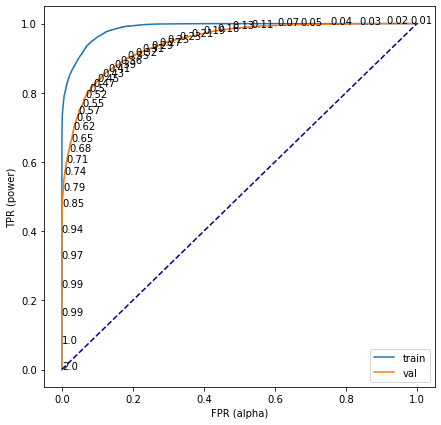

In [68]:
voting.ensemble_get_scores({}, skf)

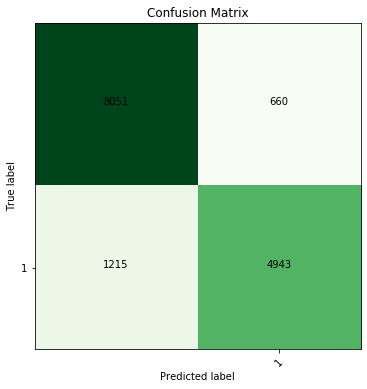

In [69]:
voting.ensemble_pretty_conf_matrix()

## 5.7. AdaBoost

### 5.7.1. AdaBoost - Logistic Regression

In [70]:
estimators = logistic_regression1.best_model
adaboost1 = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.879088,0.876417


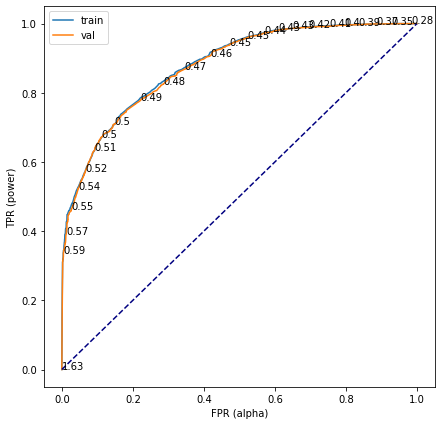

In [71]:
adaboost1.ensemble_get_scores({}, skf)

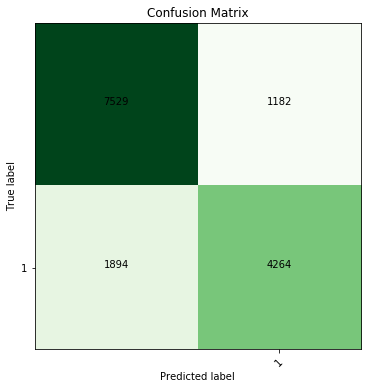

In [72]:
adaboost1.ensemble_pretty_conf_matrix()

### 5.7.2. AdaBoost - Decision Tree

In [73]:
estimators = decision_tree3.best_model
adaboost2 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.99973,0.942926


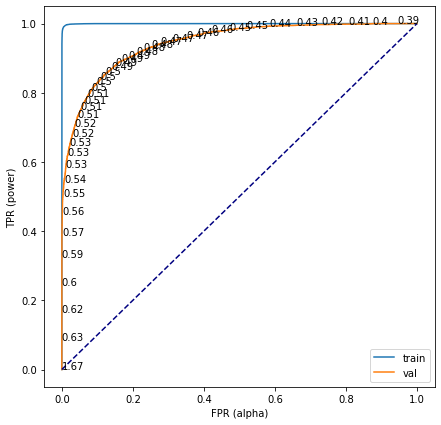

In [74]:
adaboost2.ensemble_get_scores({}, skf)

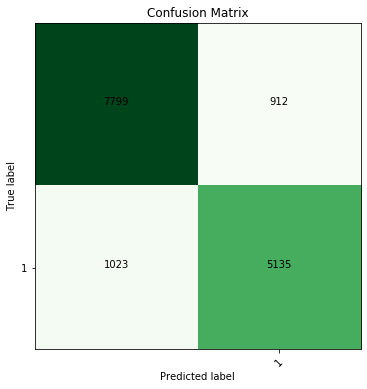

In [75]:
adaboost2.ensemble_pretty_conf_matrix()

### 5.7.3. AdaBoost - Random Forest

In [76]:
estimators = random_forest4.best_model
adaboost3 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.999943,0.909594


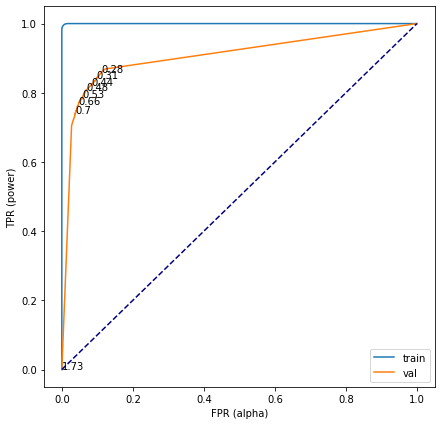

In [77]:
adaboost3.ensemble_get_scores({}, skf)

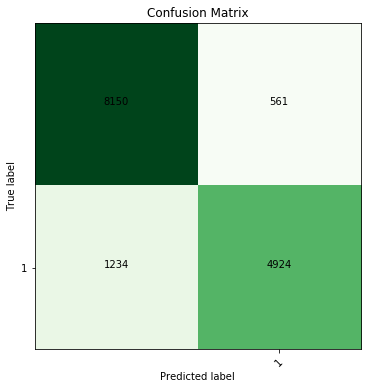

In [78]:
adaboost3.ensemble_pretty_conf_matrix()

### 5.7.4. AdaBoost - Voting Classifier

In [79]:
estimators = voting.best_model
adaboost4 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.999944,0.946835


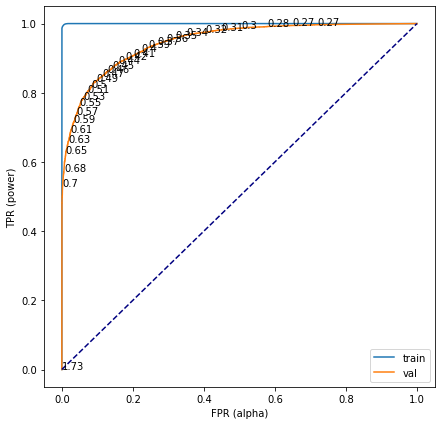

In [80]:
adaboost4.ensemble_get_scores({}, skf)

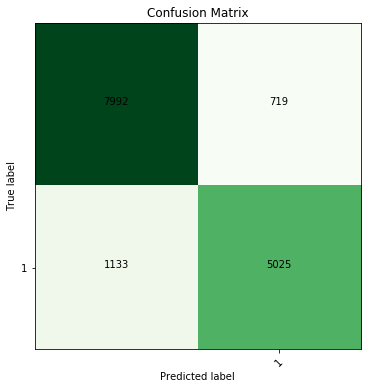

In [81]:
adaboost4.ensemble_pretty_conf_matrix()

## 5.8. XGBoost

In [82]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,XGBoost,0.922704,0.921865


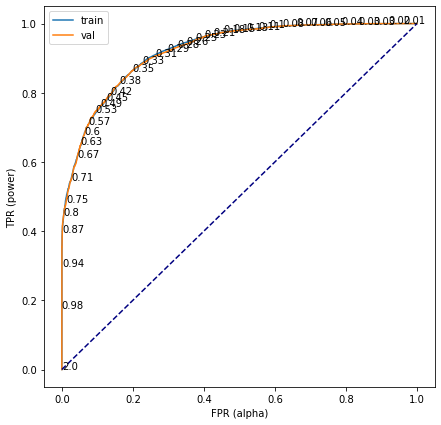

In [83]:
xgboost.ensemble_get_scores({}, skf)

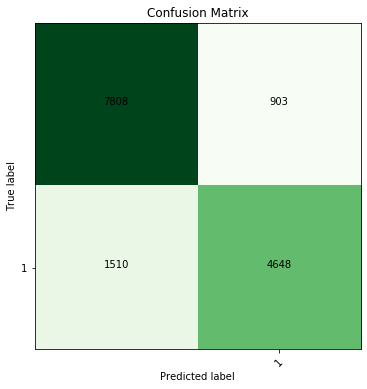

In [84]:
xgboost.ensemble_pretty_conf_matrix()

## 5.9. Stacking

In [85]:
estimators = [('lr',logistic_regression2.best_model), 
              ('dt', decision_tree3.best_model), 
              ('rnd', random_forest4.best_model)]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Stacking,0.999371,0.953402


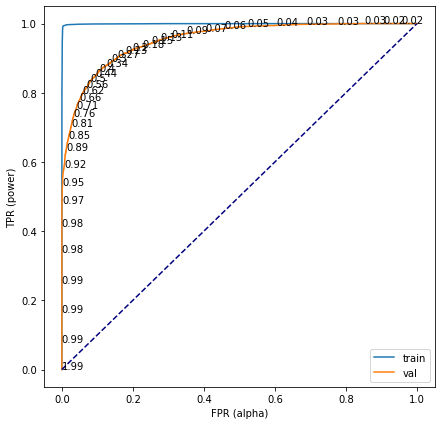

In [86]:
stacking.ensemble_get_scores({}, skf)

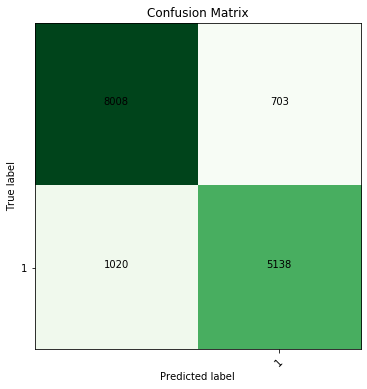

In [87]:
stacking.ensemble_pretty_conf_matrix()

# 6. Model Evaluation

In [111]:
model_evaluation_list = [logistic_regression1.scores_table,
                         logistic_regression2.scores_table, 
                         decision_tree1.scores_table, 
                         decision_tree2.scores_table, 
                         decision_tree3.scores_table, 
                         random_forest1.scores_table, 
                         random_forest2.scores_table,
                         random_forest3.scores_table,
                         random_forest4.scores_table,
                         voting.scores_table,
                         adaboost1.scores_table,
                         adaboost2.scores_table,
                         adaboost3.scores_table,
                         adaboost4.scores_table,
                         xgboost.scores_table,
                         stacking.scores_table]

model_names = ['logistic_regression1',
               'logistic_regression2', 
               'decision_tree1',
               'decision_tree2',
               'decision_tree3',
               'random_forest1',
               'random_forest2', 
               'random_forest3',
               'random_forest4',
               'voting',
               'adaboost1 (log_reg)',
               'adaboost2 (d_tree)',
               'adaboost3 (rand_forest)',
               'adaboost4 (voting)',
               'xgboost',
               'stacking (log_reg, d_tree, rand_forest)']

In [112]:
model_evaluation_df = pd.concat(model_evaluation_list)

In [113]:
model_evaluation_df['Model'] = model_names

In [116]:
model_evaluation_df.sort_values(by='Validation AUC', ascending=False, inplace=True)
model_evaluation_df.reset_index(drop=True, inplace=True)

In [117]:
model_evaluation_df

,Model,Train AUC,Validation AUC
0,"stacking (log_reg, d_tree, rand_forest)",0.999371,0.953402
1,random_forest1,0.999528,0.952546
2,random_forest3,0.999469,0.952503
3,random_forest4,0.999469,0.952503
4,random_forest2,0.999208,0.951905
5,adaboost4 (voting),0.999944,0.946835
6,voting,0.986979,0.945026
7,adaboost2 (d_tree),0.999730,0.942926
8,decision_tree3,0.938816,0.924455
9,decision_tree2,0.948526,0.923626


The dataframe above lists the model performances in order of their validation auc roc scores. Stacking was the best performer however its performance is only approximately one thousandth greater than the random forest models. As stacking takes in multiple models its complexity is greater than the random forest models and due to the very minimal gains in performance it was decided not to use this model. The first iteration of random forest was the second best performer, however as discussed earlier, there were reproducibility problems possibly due to the multicore processing occuring. The third and fourth iterations of random forest were next, both of which showed that the best performer was max_depth=70 and min_samples_leaf=1. This is the final model chosen due to its high performance and relative simplicity when compared to the stacking model. 

# 7. Feature Importance

In this section the relative importance of the features from the chosen random forest model are deduced.

In [67]:
final_model = random_forest4.best_model

In [68]:
feature_importance = pd.DataFrame(final_model.feature_importances_)

In [69]:
feature_importance.rename(columns={0:'Importance'}, inplace=True)

In [70]:
feature_importance['Feature'] = X_s.columns

In [71]:
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

In [72]:
feature_importance.head(20)

,Importance,Feature
0,0.101343,LeadTime
232,0.081141,Country_PRT
11,0.074694,TotalOfSpecialRequests
9,0.060365,ADR
6,0.046779,PreviousCancellations
522,0.029017,CustomerType_Transient
2,0.027794,StaysInWeekNights
523,0.020519,CustomerType_Transient-Party
1,0.019357,StaysInWeekendNights
278,0.017951,MarketSegment_Online TA


In [73]:
top_20_features = feature_importance.head(20)

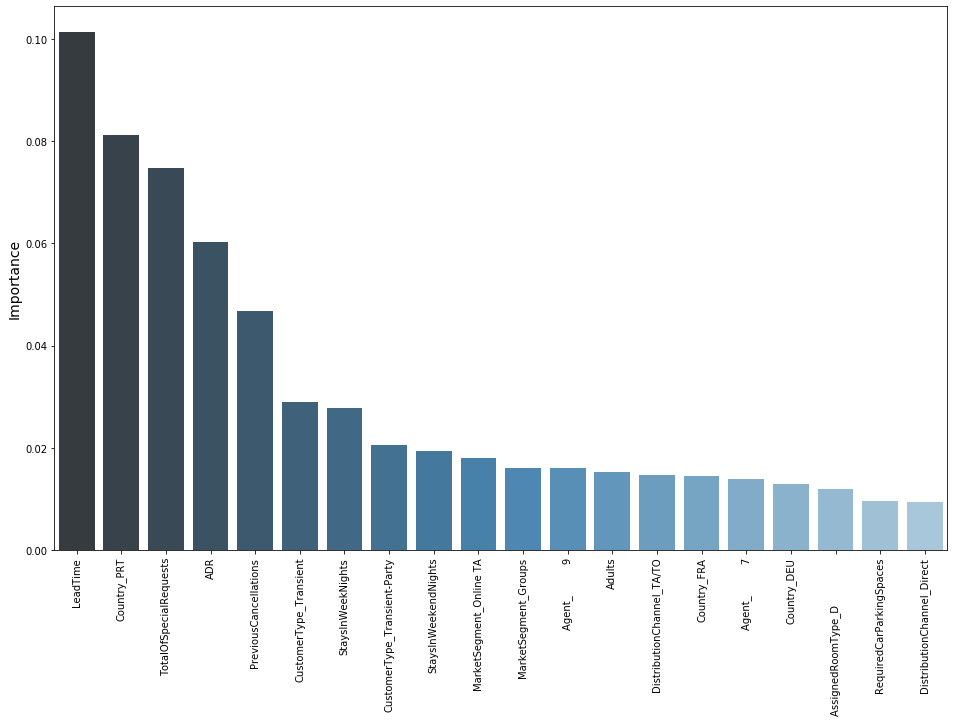

In [74]:
plt.figure(figsize=(16,10))
sns.barplot(x='Feature', y='Importance', data=top_20_features, palette="Blues_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()

Its clear from this graph that the majority of the prodictive power in the model comes from 5 features. In order they are as follows:

1. LeadTime: the time between the booking being made and the check-in date.
2. Country_PRT: if the booking was made from Portugal. The identity of the hotel was kept anonymous in the dataset, however Portugal had the highest number of bookings, so it is assued that the hotel is based somewhere within the country.
3. TotalOfSpecialRequests: the number of special requests made in the booking. A special request is when a customer asks for anything that does not come standard in the booking (i.e. a certain number of beds in the room or special linen).
4. ADR: the Average Daily Rate. This could be considered a proxy for whether or not the hotel is in a busy period at the check-in date.
5. PreviousCancellations: the number of times the customer has cancelled previous bookings.

The following code plots the cancellation rates for each of the 5 most important features.

In [191]:
full_df = pd.concat([X, y], join='outer', axis=1)
full_df = full_df[['LeadTime',
                   'Country_PRT',
                   'TotalOfSpecialRequests',
                   'ADR',
                   'PreviousCancellations',
                   'IsCanceled']]

full_df['LeadTime'] = pd.qcut(full_df['LeadTime'], 10)
full_df['ADR'] = pd.qcut(full_df['ADR'], 10)

In [192]:
prt_df = full_df.groupby('Country_PRT').mean().reset_index()

In [193]:
special_requests_df = full_df.groupby('TotalOfSpecialRequests').mean().reset_index()

In [194]:
previous_cancellations_df = full_df.groupby('PreviousCancellations').mean().reset_index()

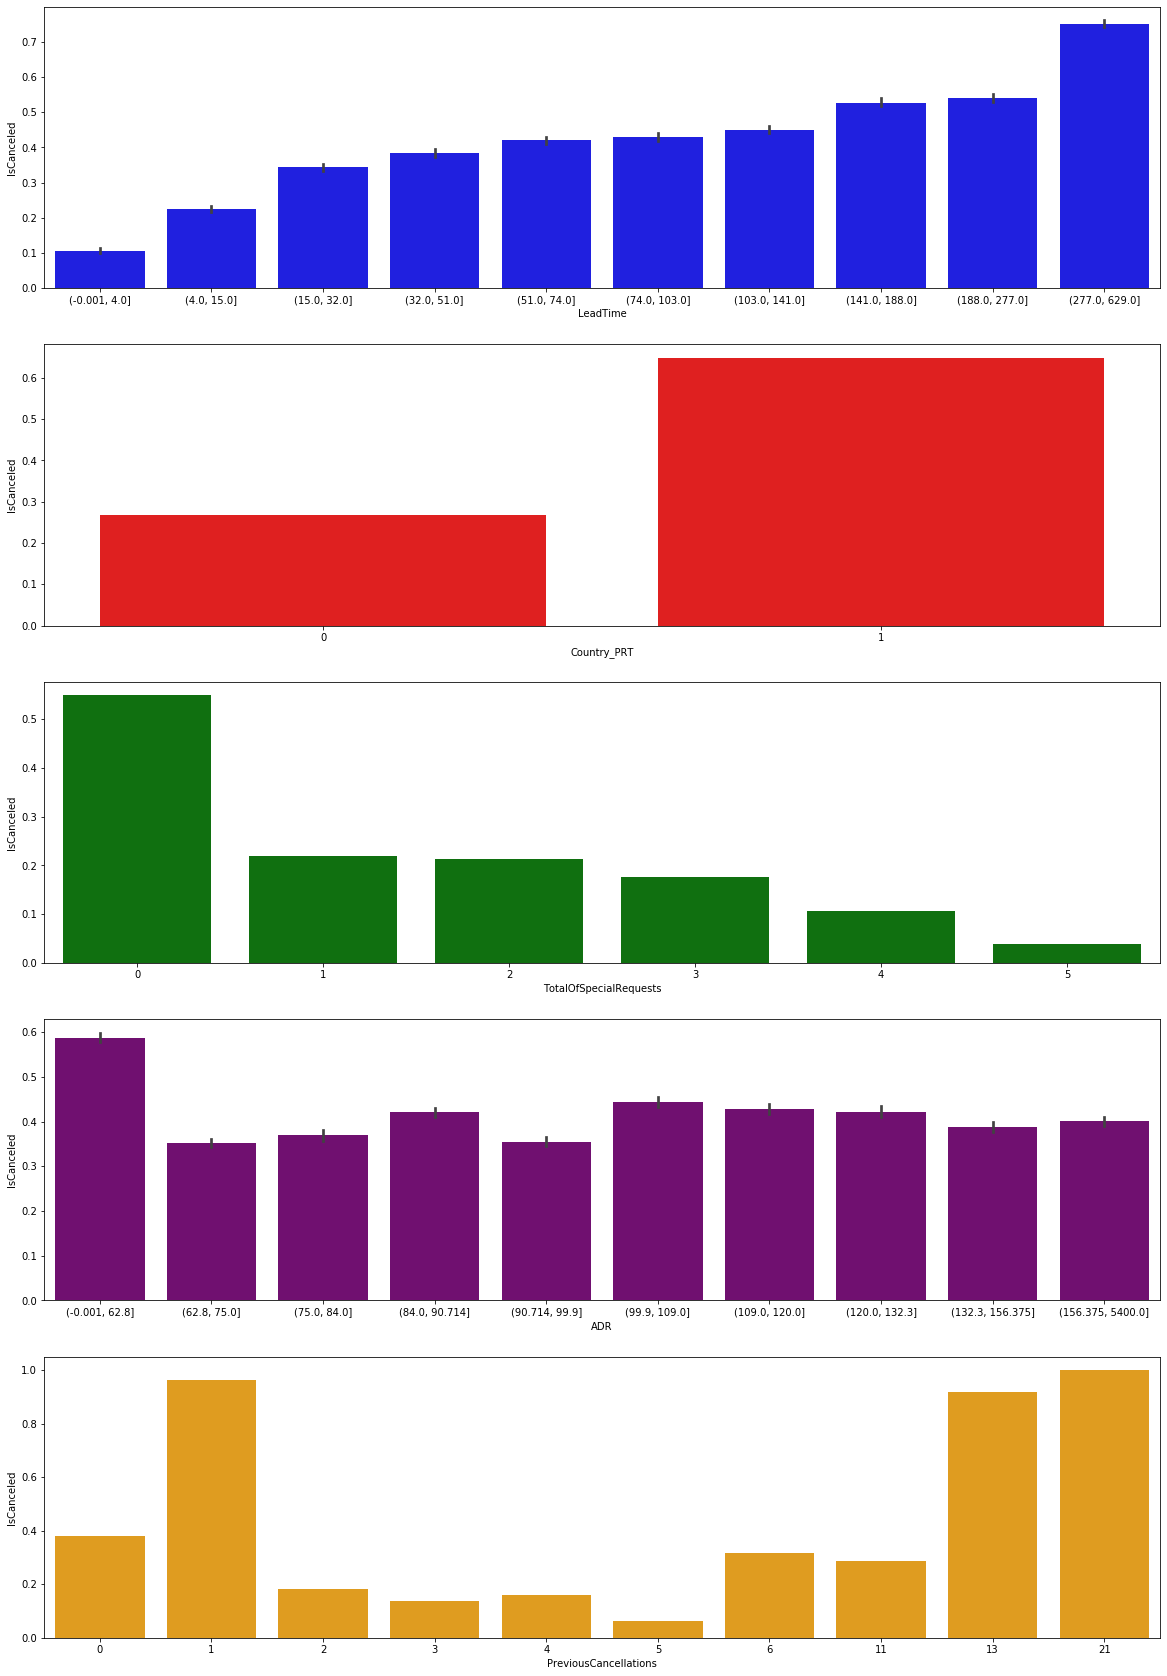

In [196]:
fig, ax = plt.subplots(5, 1, figsize=(20,30))

sns.barplot(x='LeadTime', 
            y='IsCanceled',
            data=full_df,
            color='blue',
            label='Lead Time',
            ax=ax[0])
sns.barplot(x='Country_PRT', 
            y='IsCanceled',
            data=prt_df,
            color='red',
            label='Country of booking is Portugal (1=Yes, 0=No)',
            ax=ax[1])
sns.barplot(x='TotalOfSpecialRequests', 
            y='IsCanceled',
            data=special_requests_df,
            color='green',
            label='Total Number of Special Requests',
            ax=ax[2])
sns.barplot(x='ADR', 
            y='IsCanceled',
            data=full_df,
            color='purple',
            label='Average Daily Rate',
            ax=ax[3])
sns.barplot(x='PreviousCancellations', 
            y='IsCanceled',
            data=previous_cancellations_df,
            color='orange',
            label='Number of Previous Cancellations',
            ax=ax[4])
plt.show()

# 8. Threshold Selection & Actionable Recommendations

In this section the optimum threshold for the final random forest model is calculated. The threshold is the probability beyond which the model determines that the instance is of the positive class. For example, if the threshold is set to 0.5, if the model deems that the individual has a 0.51 probablity of cancelling, it says that the individual is of high risk to cancel. If the model predicts that the individual has a 0.49 probability of cancelling, it determines that the individual is not in the high risk category. The optimum threshold is not necessarily 0.5, this has to be determined based on the cost of true positives, true negatives, false positves and false negatives in order to have the maximum returns for our client.

In [215]:
df['IsCanceled'].value_counts()

0    46226
1    33076
Name: IsCanceled, dtype: int64

The prevalence of the dataset is calculated as the total instances of the positive class / the total number of instances.

In [216]:
prev = round(33076/(33076+46226),4)
prev

0.4171

Next, the cost of true positives, true negatives, false positives and false negatives were determined. First the average booking cost was calculated by multiplying the total nights stay of each booking and the average daily rate.

In [217]:
full_df2 = pd.concat([X, y], join='outer', axis=1)
full_df2 = full_df2[['StaysInWeekendNights','StaysInWeekNights', 'ADR']]
full_df2['revenue'] = (full_df2['StaysInWeekendNights']+full_df2['StaysInWeekNights'])*full_df2['ADR']
full_df2['revenue'].sum()/len(full_df2)

318.7246533504829

Rounding the figure above, the average cost of each booking is approximately 320€. The flat deposit rate is 25% (80€). The deposit is to be increased to 50% (160€) for individuals that are classified as high risk of cancellation. This is an increased revenue of 80€ for those who do cancel. It is assumed that 10% of individuals that are faced with a higher deposit will not go through with the booking (averages at 32€ per customer).

In [218]:
ctp = 48 # cost of true positives (80€ - 32€)
cfp = -32 # cost of false positives
ctn = 0 # cost of true negatives (business as usual)
cfn = 0 # cost of false negatives (business as usual)

In [219]:
m = ((1-prev)/prev) * ((cfp-ctn)/(cfn-ctp))
m

0.9316710620954206

In [220]:
model = random_forest4.best_model

In [221]:
model.fit(X_val, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In the following code the false positives rate and true positive rate are calculated for each threshold.

In [222]:
val_prob = model.predict_proba(X_val)[:,1]

In [223]:
fpr, tpr, thresh = roc_curve(y_val, val_prob)

In [224]:
df_roc = pd.DataFrame()

In [225]:
df_roc['fpr'] = fpr
df_roc['tpr'] = tpr
df_roc['thresh'] = thresh

The fm score is then calculated for each threshold. This is then sorted by fm score. The threshold with the largest fm provides the greatest returns for the client.

In [229]:
for i in df_roc.index:
    df_roc.loc[i, 'fm'] = df_roc.loc[i, 'tpr'] - (m * df_roc.loc[i, 'fpr'])

In [230]:
df_roc.sort_values(by='fm', ascending=False, inplace=True)

In [231]:
df_roc.head()

,fpr,tpr,thresh,fm
383,0.003444,0.997889,0.448167,0.994680
382,0.002985,0.997239,0.514073,0.994459
381,0.002755,0.996915,0.527833,0.994348
385,0.004133,0.998051,0.398643,0.994201
380,0.002411,0.996427,0.549159,0.994181


In [269]:
threshold = 0.448167

The best threshold is 0.452305. This means any individual that has a probability > 0.452305 of being likely to cancel will be flagged as a high risk individual.

The model is then fit to the test dataset and the probability for each instance is calculated.

In [270]:
model.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [271]:
predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

In [272]:
unique, counts = np.unique(predicted, return_counts=True)
dict(zip(unique, counts))

{0: 11528, 1: 8298}

The following two cells contain the functions used to plot the confusion matrix (taken from the model classes).

In [273]:
def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm

In [274]:
def plot_conf_matrix(y_true, y_predicted):
        
        cnf_matrix = confusion_matrix(y_true, predicted)
        
        plt.figure(figsize=(8,18))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

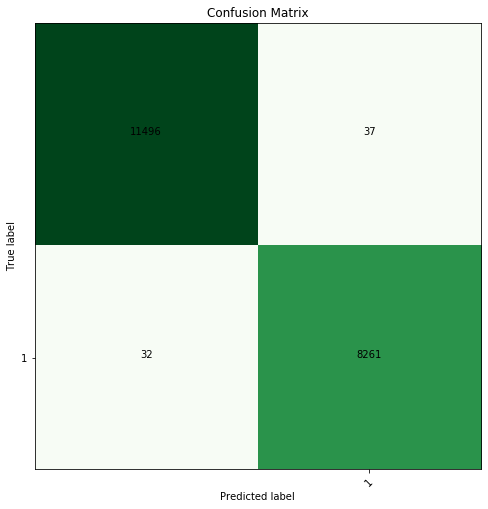

In [275]:
plot_conf_matrix(y_test['IsCanceled'], predicted)

From the confusion matrix we can see that there are:

- 8261 true positives.
- 11496 true negatives.
- 37 false positives.
- 32 false negatives.

The steps to calculate the increased returns for our client with every 1000 boookings were as follows:

In [277]:
true = 8261/(8261+37)
true

0.9955410942395758

In [278]:
false = 11496/(11496+32)
false

0.9972241498959056

In [286]:
real_ctp = ctp*8261
real_cfp = cfp*37
real_ctn = 0
real_cfp = 0

total_gains = real_ctp + real_cfp + real_ctn + real_cfp

total_instances = len(y_test)

gains_per_1000_bookings = (total_gains/total_instances)*1000
gains_per_1000_bookings

20000.403510541713

The dataset conatins every booking made in a two year period, therefore the total increase in revenue per year is:

In [288]:
gains_per_year = round((total_gains/total_instances)*(len(df)/2), 0)
gains_per_year

793036.0